# Clasificacion Automatica de Tickets con NLP

### Grupo K
* Jorge Torrico

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [9]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

## Importing the necessary libraries

In [10]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Loading

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [12]:
from google.colab import files
import pandas as pd
import json

# Cargar el archivo JSON utilizando files.upload()
uploaded = files.upload()
archivo_json = list(uploaded.keys())[0]

with open(archivo_json, 'r', encoding='utf-8') as archivo:
    # Carga el contenido JSON del archivo en un diccionario
    data = json.load(archivo)

# Convertir el diccionario en un DataFrame usando json_normalize
df = pd.json_normalize(data)


Saving complaints.json to complaints.json


In [13]:
# Imprimir el DataFrame
print(df)

                    _index      _type      _id  _score   _source.tags  \
0      complaint-public-v2  complaint  3211475     0.0           None   
1      complaint-public-v2  complaint  3229299     0.0  Servicemember   
2      complaint-public-v2  complaint  3199379     0.0           None   
3      complaint-public-v2  complaint  2673060     0.0           None   
4      complaint-public-v2  complaint  3203545     0.0           None   
...                    ...        ...      ...     ...            ...   
78308  complaint-public-v2  complaint  3105617     0.0           None   
78309  complaint-public-v2  complaint  3091984     0.0           None   
78310  complaint-public-v2  complaint  3133355     0.0           None   
78311  complaint-public-v2  complaint  3110963     0.0           None   
78312  complaint-public-v2  complaint  2001189     0.0           None   

      _source.zip_code _source.complaint_id  \
0                90301              3211475   
1                319XX       

## Data preparation

In [14]:
# Inspección de los datos
print(df.head())

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

In [15]:
# Tipos de datos del Datafram
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [16]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [17]:
#Mostrar nombres de las columnas
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [18]:
# Verificar valores nulos en las columnas
print(df.isnull().any())

_index                               False
_type                                False
_id                                  False
_score                               False
_source.tags                          True
_source.zip_code                      True
_source.complaint_id                 False
_source.issue                        False
_source.date_received                False
_source.state                         True
_source.consumer_disputed            False
_source.product                      False
_source.company_response             False
_source.company                      False
_source.submitted_via                False
_source.date_sent_to_company         False
_source.company_public_response       True
_source.sub_product                   True
_source.timely                       False
_source.complaint_what_happened      False
_source.sub_issue                     True
_source.consumer_consent_provided     True
dtype: bool


In [19]:
# Cantidad de nulos por columna
print(df.isnull().sum())

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64


In [20]:
# Eliminar columnas con valores nulos
df.drop(columns=['_source.tags', '_source.company_public_response', '_source.sub_issue'],inplace = True)

In [21]:
# Mostrar la cantidad de nulos por columna
print(df.isnull().sum())

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.consumer_consent_provided     1008
dtype: int64


In [22]:
# Valores unicos en los datos
df.nunique()

_index                                   1
_type                                    1
_id                                  78313
_score                                   1
_source.zip_code                      9442
_source.complaint_id                 78313
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.consumer_consent_provided        5
dtype: int64

In [23]:
# Eliminar columnas con valores unicos
df.drop(columns=['_id','_source.complaint_id'], inplace=True)

In [24]:
# Eliminar valores duplicados
df.drop_duplicates(inplace=True)

In [25]:
df

,_index,_type,_score,_source.zip_code,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.consumer_consent_provided
0,complaint-public-v2,complaint,0.0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided
1,complaint-public-v2,complaint,0.0,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided
2,complaint-public-v2,complaint,0.0,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided
3,complaint-public-v2,complaint,0.0,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided
4,complaint-public-v2,complaint,0.0,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,0.0,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided
78309,complaint-public-v2,complaint,0.0,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided
78310,complaint-public-v2,complaint,0.0,923XX,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Consent provided
78311,complaint-public-v2,complaint,0.0,None,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Consent provided


In [26]:
#Renombrar columnas
df.rename(columns={"_index":"index", "_type":"type", "_score":"score","_source.zip_code":"zip_code","_source.issue":"issue", "_source.date_received":"date_received", "_source.state": "state", "_source.consumer_disputed": "consumer_disputed", "_source.product": "product", "_source.company_response": "company_response", "_source.company":"company", "_source.submitted_via": "submitted_via", "_source.date_sent_to_company": "date_sent_to_company", "_source.sub_product": "sub_product", "_source.timely":"timely", "_source.complaint_what_happened": "complaint_what_happened", "_source.consumer_consent_provided": "consumer_conset_provided"}, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77712 entries, 0 to 78312
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     77712 non-null  object 
 1   type                      77712 non-null  object 
 2   score                     77712 non-null  float64
 3   zip_code                  71012 non-null  object 
 4   issue                     77712 non-null  object 
 5   date_received             77712 non-null  object 
 6   state                     75758 non-null  object 
 7   consumer_disputed         77712 non-null  object 
 8   product                   77712 non-null  object 
 9   company_response          77712 non-null  object 
 10  company                   77712 non-null  object 
 11  submitted_via             77712 non-null  object 
 12  date_sent_to_company      77712 non-null  object 
 13  sub_product               67245 non-null  object 
 14  timely

In [28]:
# Formatear el tipo de dato fecha
df['date_received'] = pd.to_datetime(df['date_received'])
df['date_sent_to_company'] = pd.to_datetime(df['date_sent_to_company'])

In [29]:
# Cambiar columnas object a category
dtypes_dict = {'index':'category','type':'category', 'zip_code':'category', 'state':'category', 'consumer_disputed':'category', 'company':'category', 'submitted_via':'category', 'product':'category', 'sub_product':'category', 'timely':'category', 'consumer_conset_provided':'category'}
df = df.astype(dtypes_dict)

In [30]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,77712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Diccionario de elementos unicos
cols=['type', 'state', 'company', 'product', 'sub_product','submitted_via']

def get_categories(df, colums):
  for col in colums:
    print(dict(enumerate(df[col].cat.categories)))

get_categories(df,cols)

{0: 'complaint'}
{0: 'AA', 1: 'AE', 2: 'AK', 3: 'AL', 4: 'AP', 5: 'AR', 6: 'AS', 7: 'AZ', 8: 'CA', 9: 'CO', 10: 'CT', 11: 'DC', 12: 'DE', 13: 'FL', 14: 'FM', 15: 'GA', 16: 'GU', 17: 'HI', 18: 'IA', 19: 'ID', 20: 'IL', 21: 'IN', 22: 'KS', 23: 'KY', 24: 'LA', 25: 'MA', 26: 'MD', 27: 'ME', 28: 'MH', 29: 'MI', 30: 'MN', 31: 'MO', 32: 'MS', 33: 'MT', 34: 'NC', 35: 'ND', 36: 'NE', 37: 'NH', 38: 'NJ', 39: 'NM', 40: 'NV', 41: 'NY', 42: 'OH', 43: 'OK', 44: 'OR', 45: 'PA', 46: 'PR', 47: 'PW', 48: 'RI', 49: 'SC', 50: 'SD', 51: 'TN', 52: 'TX', 53: 'UNITED STATES MINOR OUTLYING ISLANDS', 54: 'UT', 55: 'VA', 56: 'VI', 57: 'VT', 58: 'WA', 59: 'WI', 60: 'WV', 61: 'WY'}
{0: 'JPMORGAN CHASE & CO.'}
{0: 'Bank account or service', 1: 'Checking or savings account', 2: 'Consumer Loan', 3: 'Credit card', 4: 'Credit card or prepaid card', 5: 'Credit reporting', 6: 'Credit reporting, credit repair services, or other personal consumer reports', 7: 'Debt collection', 8: 'Money transfer, virtual currency, or mone

In [32]:
# Mostrar valores por categoria
def counting_number_of_values_per_cat(df, colums):
   for col in colums:
    print("Number Of Values per Category: "+col)
    print(df[col].value_counts())

counting_number_of_values_per_cat(df, cols)

Number Of Values per Category: type
complaint    77712
Name: type, dtype: int64
Number Of Values per Category: state
CA                                      13909
NY                                       8700
FL                                       6776
TX                                       5824
IL                                       4104
                                        ...  
UNITED STATES MINOR OUTLYING ISLANDS        3
MH                                          3
AA                                          3
PW                                          1
AS                                          1
Name: state, Length: 62, dtype: int64
Number Of Values per Category: company
JPMORGAN CHASE & CO.    77712
Name: company, dtype: int64
Number Of Values per Category: product
Mortgage                                                                        22636
Checking or savings account                                                     12072
Credit card or prepaid card    

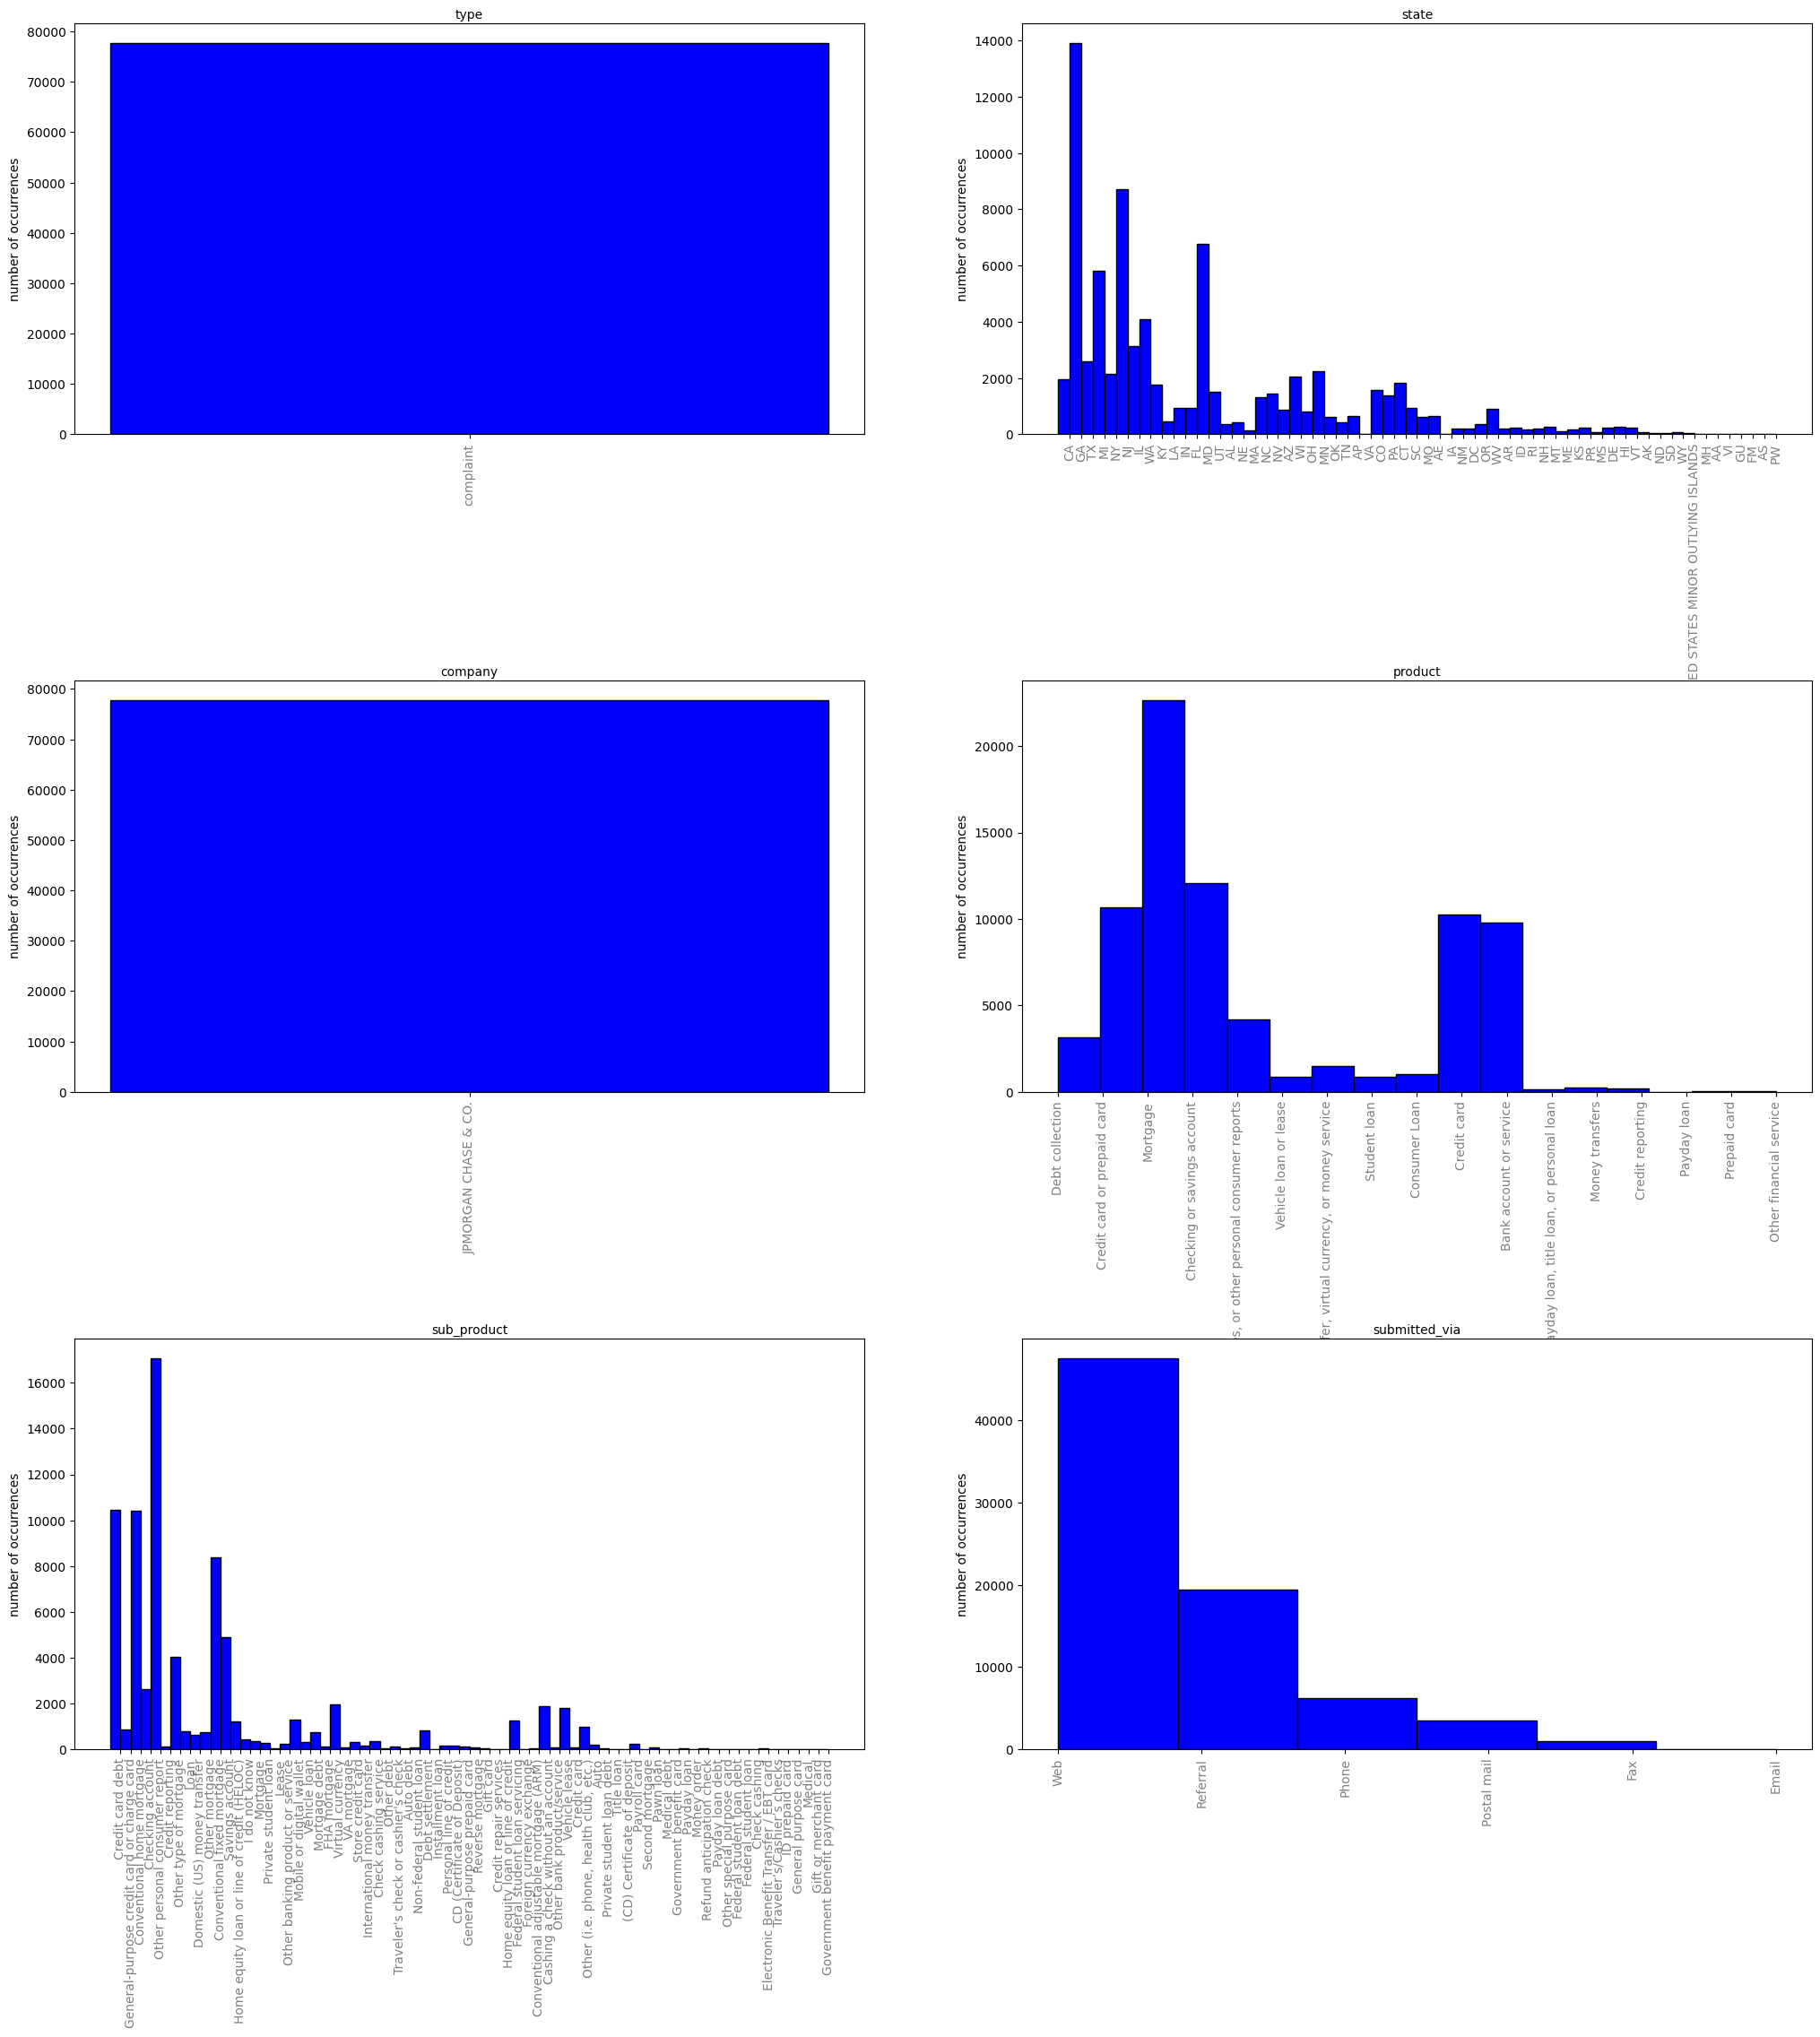

In [34]:
# Gráfica de histogramas
from IPython.core.pylabtools import figsize
def plot_categorical_values(df, cols):
  rows = int(len(cols)/2)
  fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(25, 25))
  fig.subplots_adjust(hspace = .6, wspace=.2)

  fact_cat = []
  for col in cols:
    factorized, categories = pd.factorize(df[col])
    fact_cat.append((factorized,categories, col))

  for cat, ax in zip(fact_cat, axes.flat):
    ax.hist(cat[0], bins=len(cat[1]), color='blue', ec="black")
    ax.set_xticks(range(len(cat[1])), cat[1], rotation='vertical', alpha=0.5)
    ax.set_xlabel(cat[2])
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('number of occurrences')
  plt.show()

plot_categorical_values(df, cols)

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [35]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics.plot import plot_roc_curve
from pprint import pprint


In [36]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [37]:
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77712 entries, 0 to 78312
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype                                 
---  ------                    --------------  -----                                 
 0   index                     77712 non-null  category                              
 1   type                      77712 non-null  category                              
 2   score                     77712 non-null  float64                               
 3   zip_code                  71012 non-null  category                              
 4   issue                     77712 non-null  object                                
 5   date_received             77712 non-null  datetime64[ns, pytz.FixedOffset(-300)]
 6   state                     75758 non-null  category                              
 7   consumer_disputed         77712 non-null  category                              
 8   product                   

In [39]:
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [40]:
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,score,zip_code,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_conset_provided


In [41]:
df.shape

(77712, 17)

In [42]:
df = df[~df['complaint_what_happened'].isnull()]

In [43]:
df.shape

(21009, 17)

In [44]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [45]:
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent)
    pattern = '\w*\d\w*' # Removing words with numbers in between
    sent = re.sub(pattern, '', sent)
    return sent

In [46]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [47]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [48]:
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [49]:
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [50]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [51]:
def get_POS_tags(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

In [52]:
df_clean['complaint_POS_removed'] = df_clean['complaint_lemmatized'].apply(get_POS_tags)

In [53]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

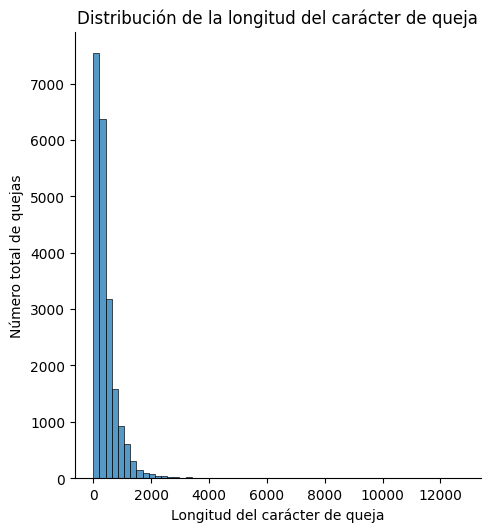

In [54]:
# visualizamos los datos de acuerdo con la longitud del carácter 'Queja'
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Longitud del carácter de queja")
plt.ylabel("Número total de quejas")
plt.title("Distribución de la longitud del carácter de queja")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

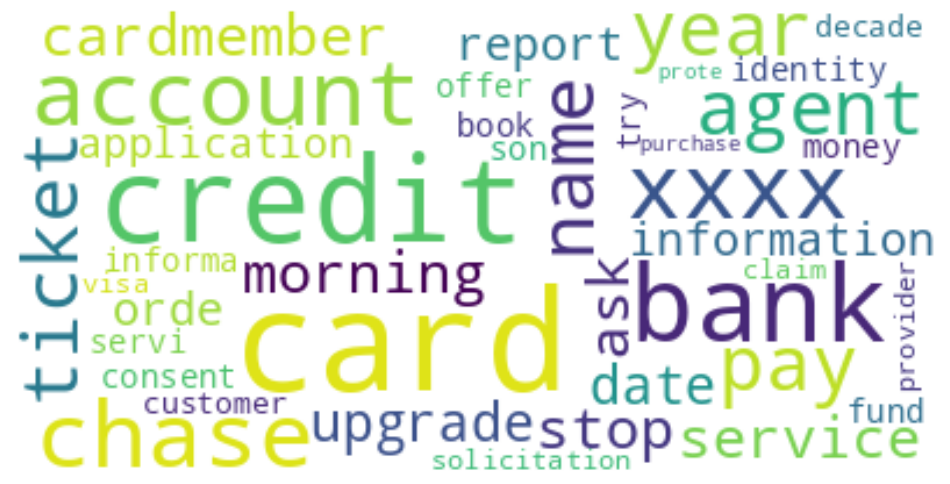

In [55]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40,
                      background_color="white", random_state=100,
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [56]:
#Removiendo los pron del cuerpo del texto
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [57]:
# Creación para poder extraer los mejores n-gramas (unigramas, bigramas, trigramas) en función de las entradas de la mismna
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [58]:
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,47470
1,chase,46672
2,xxxx,36545
3,credit,34032
4,card,29224
5,bank,28392
6,payment,21133
7,time,16005
8,charge,14990
9,day,12954


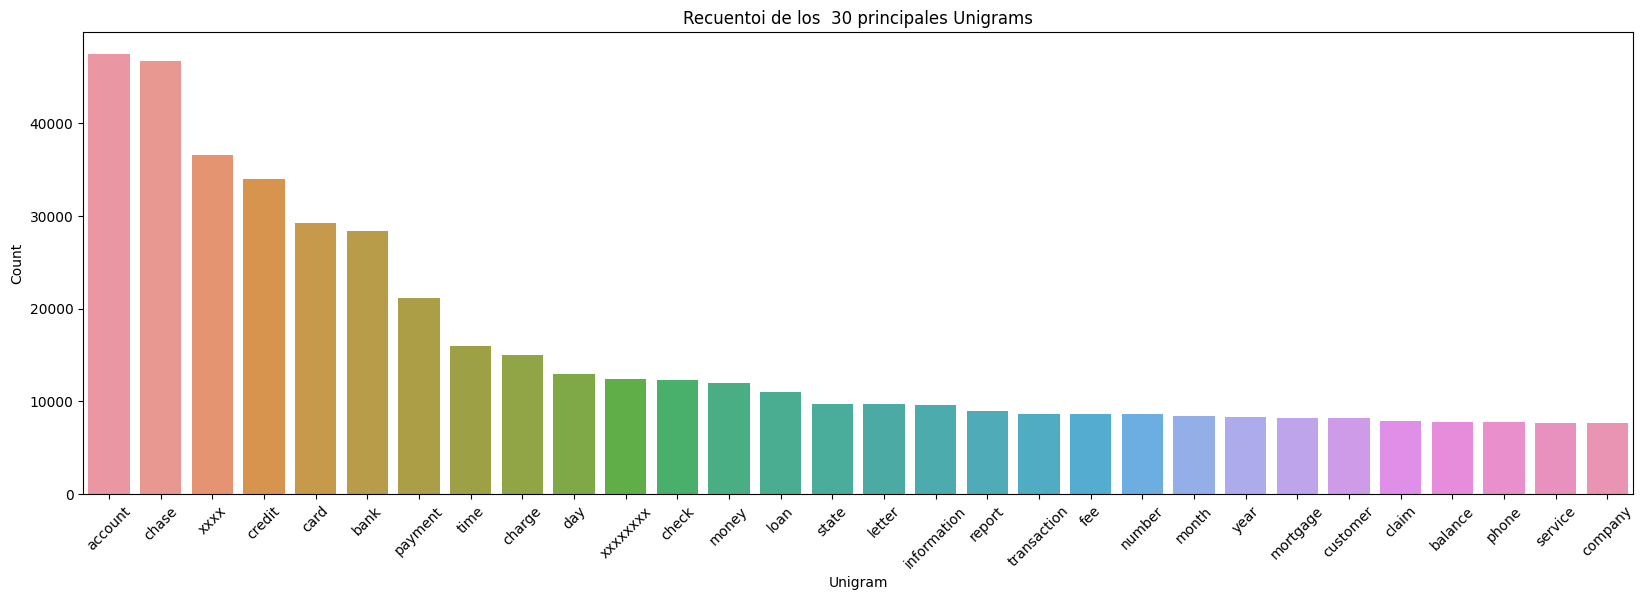

In [59]:
# traazado de los 30 mejores unigramas
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Recuentoi de los  30 principales Unigrams")
plt.show()

In [60]:
##mostrando las 10 palabras principales en la frecuencia del unigrama
df_unigram.head(10)

,unigram,count
0,account,47470
1,chase,46672
2,xxxx,36545
3,credit,34032
4,card,29224
5,bank,28392
6,payment,21133
7,time,16005
8,charge,14990
9,day,12954


In [61]:
# encuentra la frecuencia de los 30 unigramas principales entre las quejas en el marco de datos limpio (df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12760
1,xxxx xxxx,3948
2,credit report,3915
3,customer service,3078
4,chase credit,2962
5,chase bank,2938
6,bank account,2726
7,account chase,2593
8,chase account,2564
9,check account,2412


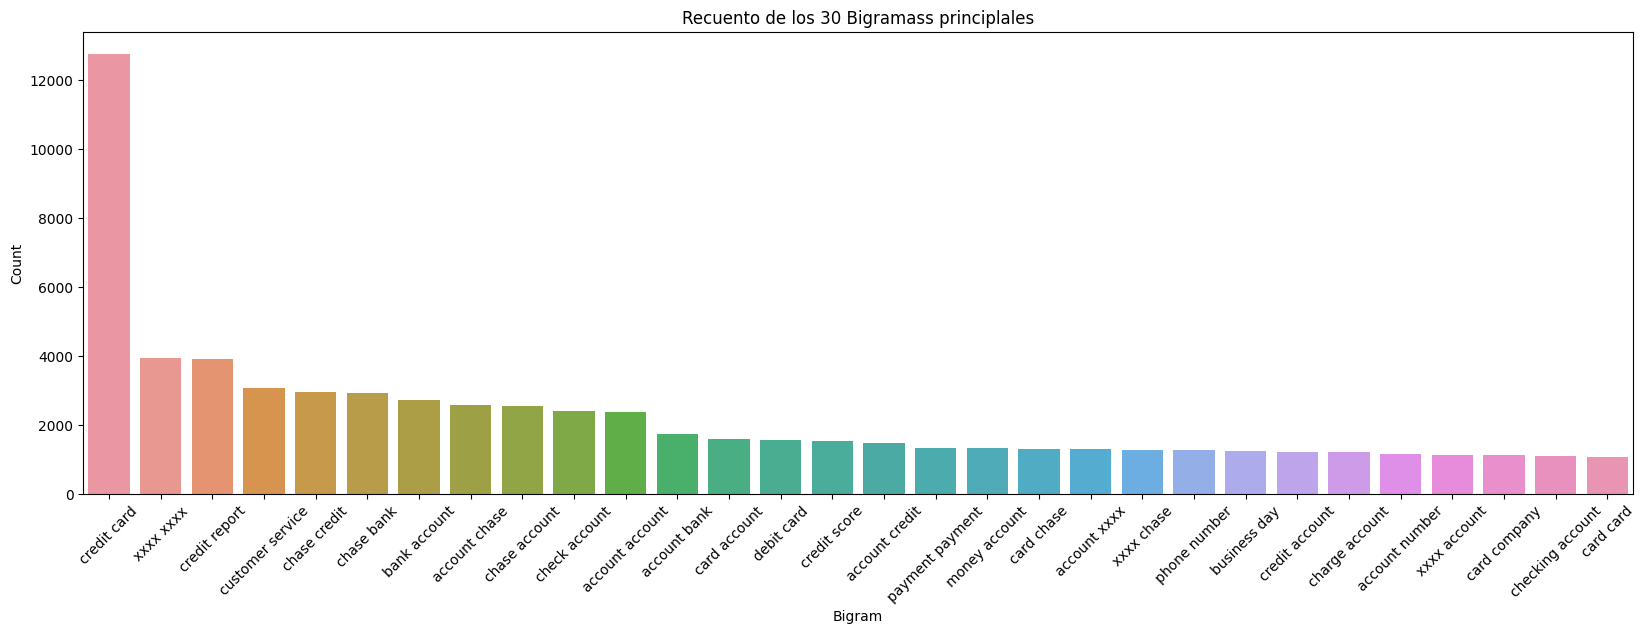

In [62]:
# Trazamos los  meojeres bimgramas en un  rango de 30
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Recuento de los 30 Bigramass principlales")
plt.show()

In [63]:
#imprimimos las 10  principales palabras en la frecuencia del bigrama
df_bigram.head(10)

,bigram,count
0,credit card,12760
1,xxxx xxxx,3948
2,credit report,3915
3,customer service,3078
4,chase credit,2962
5,chase bank,2938
6,bank account,2726
7,account chase,2593
8,chase account,2564
9,check account,2412


In [64]:
#Enciontramos la frecuencia de los 30  principales trigramas entre las quejas en el marco de datos limpios del (df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,2061
1,credit card account,1022
2,credit card company,991
3,credit card chase,631
4,credit card credit,511
5,inquiry credit report,467
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


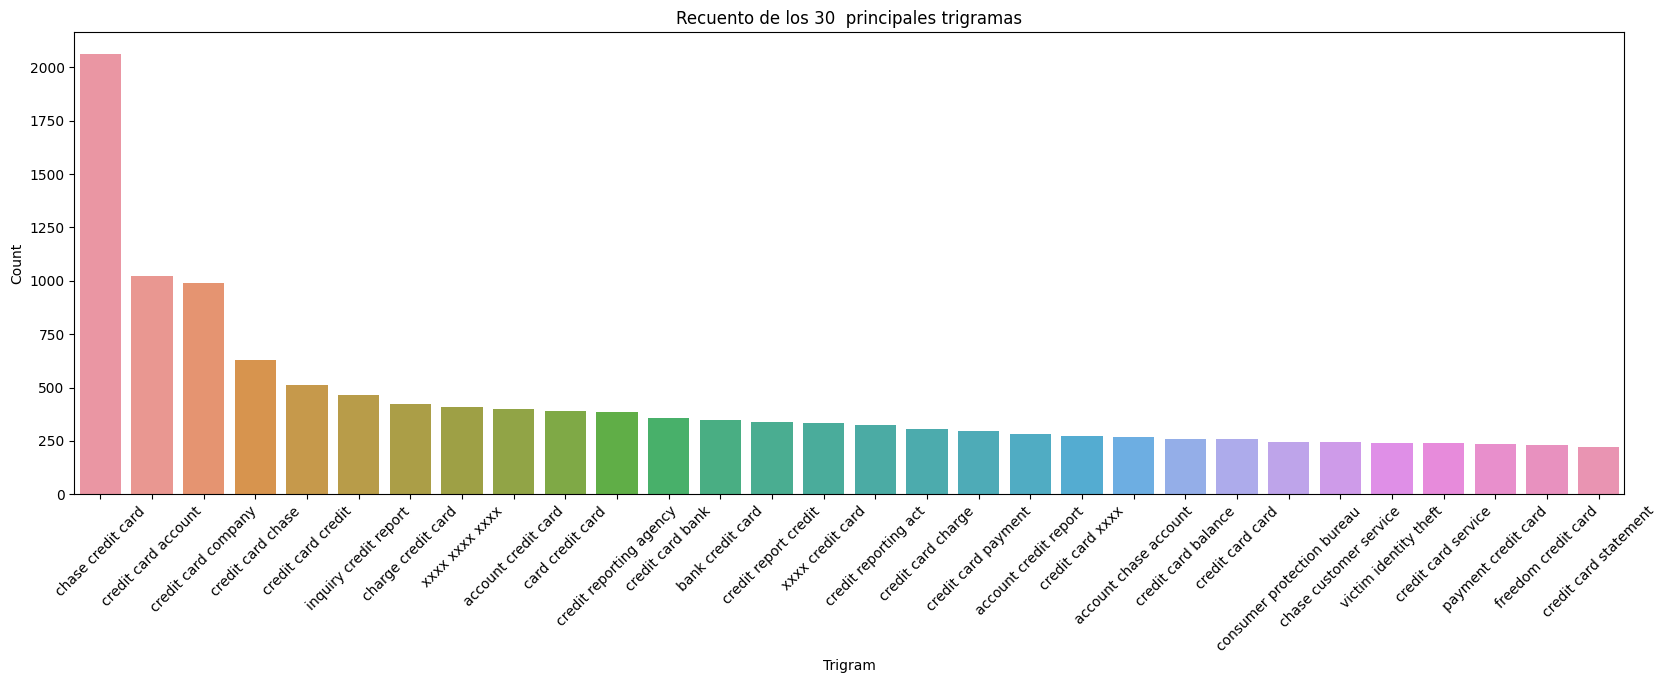

In [65]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Recuento de los 30  principales trigramas")
plt.show()

In [66]:
#Mostramos las 10  principalespalabras  en la frecuencia del trigrama
df_trigram.head(10)

,trigram,count
0,chase credit card,2061
1,credit card account,1022
2,credit card company,991
3,credit card chase,631
4,credit card credit,511
5,inquiry credit report,467
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [67]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('x{2,}','').replace('',np.nan,regex = True)
df_clean = df_clean.dropna()

In [68]:
#Todos los textos enmascarados son eliminados.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


In [69]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [70]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# inicializamos el TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [73]:
#Se crea la matriz de términos del documento transformando la columna de quejas presente en df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [74]:
dtm

<21003x7260 sparse matrix of type '<class 'numpy.float64'>'
	with 642743 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [75]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [76]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.95, min_df = 2 )
tfidf_matrix = vectorizer.fit_transform(df_clean["Complaint_clean"])

In [77]:
# NMF con 4 tópicos
nmf = NMF(n_components=4, random_state=40)

# Entrenar
nmf.fit(tfidf_matrix)

# Top 10 de palabras por tópico
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

Topic 0:
account, bank, check, money, fund, chase, deposit, branch, day, number

Topic 1:
credit, card, report, inquiry, account, chase, score, company, balance, limit

Topic 2:
payment, loan, mortgage, chase, month, home, modification, time, year, rate

Topic 3:
charge, card, fee, transaction, chase, dispute, merchant, claim, fraud, purchase



In [78]:
# NMF con 5 tópicos
nmf = NMF(n_components=5, random_state=57)

# Entrenar
nmf.fit(tfidf_matrix)

# Top 10 de palabras por tópico
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

Topic 0:
account, check, bank, money, fund, chase, deposit, branch, day, number

Topic 1:
credit, card, report, inquiry, chase, account, score, company, limit, information

Topic 2:
payment, balance, month, fee, statement, day, time, auto, date, pay

Topic 3:
charge, card, fee, transaction, dispute, chase, merchant, fraud, claim, purchase

Topic 4:
loan, mortgage, home, modification, chase, property, year, letter, rate, time



In [79]:
topics = nmf.transform(vectorizer.transform(df_clean["Complaint_clean"]))
predicted_labels = np.argmax(topics, axis=1)
df_clean['Topic'] = predicted_labels

In [80]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [81]:
#Print the first 5 Complaint for each of the Topics
df_clean_head = df_clean.groupby('Topic').head(5)
print(df_clean_head.sort_values('Topic')[["complaint_what_happened", "Topic"]].values)

[['my grand son give me check for  i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase  times they told him i should call not him to verify the check owner he is out the country most the time  date happen  check number xxxx claim number is xxxx with chase'
  0]
 ['with out notice jp morgan chase restricted my account by my debit card tuesday  on thursday  i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturda

In [82]:
#Create the dictionary of Topic names and Topics
Topic_names = {0: "Others", 1: "Theft/Dispute Reporting", 2: "Bank Account services", 3: "Credit card or prepaid card", 4: "Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic_literal'] = df_clean['Topic'].map(Topic_names)

In [83]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_literal
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1,Theft/Dispute Reporting
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0,Others
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1,Theft/Dispute Reporting
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3,Credit card or prepaid card
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3,Credit card or prepaid card
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,2,Bank Account services


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [6]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [84]:
# Eliminar valores nulos
df_clean.dropna(inplace=True)

In [85]:
# Preparar los datos de Train, Test y Validation
X = df_clean["Complaint_clean"]
y = df_clean["Topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [86]:
# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Vectorizar los datos
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [87]:
# Crear modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
lr = LogisticRegression(max_iter=250)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = MultinomialNB()

In [88]:
# Entrenar modelos
lr.fit(X_train_tfidf, y_train)
dt.fit(X_train_tfidf, y_train)
rf.fit(X_train_tfidf, y_train)
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [89]:
from sklearn.metrics import accuracy_score

# Evaluar modelos

models = [lr, dt, rf, nb]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"]
train_scores = []
val_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model in models:
    train_scores.append(cross_val_score(model, X_train_tfidf, y_train, cv=5).mean())
    val_scores.append(model.score(X_val_tfidf, y_val))
    y_val_pred = model.predict(X_val_tfidf)
    accuracy_scores.append(accuracy_score(y_val, y_val_pred))
    precision_scores.append(precision_score(y_val, y_val_pred, average="weighted"))
    recall_scores.append(recall_score(y_val, y_val_pred, average="weighted"))
    f1_scores.append(f1_score(y_val, y_val_pred, average="weighted"))

model_comparison = pd.DataFrame({
    "Model": model_names,
    "Training Score": train_scores,
    "Validation Score": val_scores,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})


In [90]:
# Imprimir resultados de comparación de modelos
print(model_comparison)


                 Model  Training Score  Validation Score  Accuracy  Precision  \
0  Logistic Regression        0.956976          0.953417  0.953417   0.953608   
1        Decision Tree        0.820594          0.817409  0.817409   0.818200   
2        Random Forest        0.856561          0.856171  0.856171   0.860543   
3          Naive Bayes        0.763966          0.748045  0.748045   0.772786   

     Recall  F1 Score  
0  0.953417  0.953350  
1  0.817409  0.817447  
2  0.856171  0.853925  
3  0.748045  0.716806  


In [91]:
# Obtener el mejor modelo
best_model_index = model_comparison["Validation Score"].idxmax()
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]
print(f"El mejor modelo es : {best_model_name}")


El mejor modelo es : Logistic Regression


In [92]:
# Validar mejor modelo
best_model.fit(X_train_tfidf, y_train)
y_val_pred = best_model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average="weighted")
recall = recall_score(y_val, y_val_pred, average="weighted")
f1 = f1_score(y_val, y_val_pred, average="weighted")
conf_matrix = confusion_matrix(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

In [93]:
# Imprimir resultados de la evaluación del mejor modelo
print(f"Best model: {best_model_name}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Best model: Logistic Regression
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


Confusion Matrix:
[[725   7   0   6   8]
 [  8 678   4  14   4]
 [ 10   6 302   8   7]
 [ 12   6   3 621  10]
 [  8   7   2   7 478]]


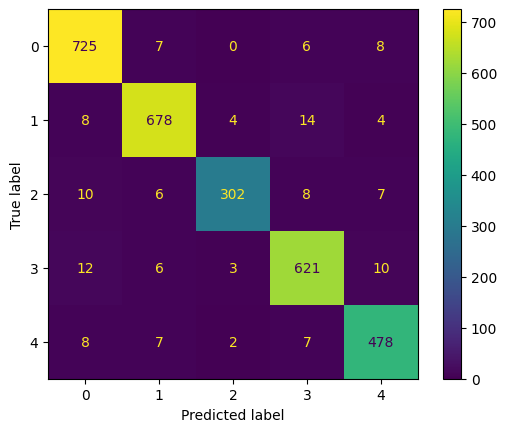

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
print(f"Confusion Matrix:\n{conf_matrix}")
ConfusionMatrixDisplay(conf_matrix, display_labels=best_model.classes_).plot()

In [95]:
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       746
           1       0.96      0.96      0.96       708
           2       0.97      0.91      0.94       333
           3       0.95      0.95      0.95       652
           4       0.94      0.95      0.95       502

    accuracy                           0.95      2941
   macro avg       0.95      0.95      0.95      2941
weighted avg       0.95      0.95      0.95      2941



In [96]:
# Obtener el mejor modelo
best_model_index = model_comparison["Validation Score"].idxmax()
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]
print(f"El mejor modelo es : {best_model_name}")


El mejor modelo es : Logistic Regression


In [97]:
# Validar mejor modelo
best_model.fit(X_train_tfidf, y_train)
y_val_pred = best_model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average="weighted")
recall = recall_score(y_val, y_val_pred, average="weighted")
f1 = f1_score(y_val, y_val_pred, average="weighted")
conf_matrix = confusion_matrix(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

In [98]:
# Imprimir resultados de la evaluación del mejor modelo
print(f"Best model: {best_model_name}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Best model: Logistic Regression
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


Confusion Matrix:
[[725   7   0   6   8]
 [  8 678   4  14   4]
 [ 10   6 302   8   7]
 [ 12   6   3 621  10]
 [  8   7   2   7 478]]


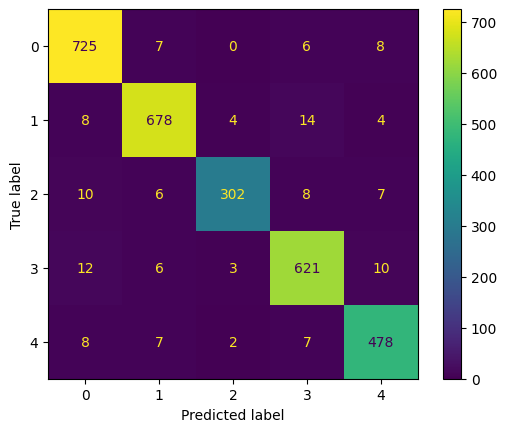

In [99]:
print(f"Confusion Matrix:\n{conf_matrix}")
ConfusionMatrixDisplay(conf_matrix, display_labels=best_model.classes_).plot()

In [100]:
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       746
           1       0.96      0.96      0.96       708
           2       0.97      0.91      0.94       333
           3       0.95      0.95      0.95       652
           4       0.94      0.95      0.95       502

    accuracy                           0.95      2941
   macro avg       0.95      0.95      0.95      2941
weighted avg       0.95      0.95      0.95      2941



In [101]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres de puntuación
    text = re.sub(r'[^\w\s]', ' ', text)

    # Eliminar números
    text = re.sub(r'\d+', ' ', text)

    # Tokenización
    tokens = word_tokenize(text)

    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Unir tokens
    text = " ".join(stemmed_tokens)

    # Extraer partes del discurso (POS)
    pos_tags = nltk.pos_tag(word_tokenize(text))
    pos_tokens = [tag[0] for tag in pos_tags if tag[1].startswith('N') or tag[1].startswith('V')]
    text = " ".join(pos_tokens)

    return text


In [102]:
def predict_topic_custom(text):
    # Preprocesar el texto personalizado
    processed_text = preprocess_text(text)

    # Vectorizar el texto preprocesado
    text_tfidf = tfidf_vectorizer.transform([processed_text])

    # Predecir el tema de la queja utilizando el mejor modelo encontrado previamente
    prediction = best_model.predict(text_tfidf)[0]

    return prediction

In [103]:
map_topic = {
    0: 'Others',
    1: 'Theft/Dispute Reporting',
    2: 'Bank Account services',
    3: 'Credit card or prepaid card',
    4: 'Mortgage/Loan'
}

In [ ]:
# leer el archivo csv y almacenar los datos en un dataframe
df_random_complaints = pd.read_csv('prueba.csv', sep='|')

def predict_and_print(df):
    # iterar sobre cada fila del dataframe
    for index, row in df.iterrows():
        # obtener la queja y el topico real
        complaint = row['complaint']
        actual_topic = row['topic']
        # obtener el topico predicho utilizando la función predict_topic_custom
        predicted_topic = predict_topic_custom(complaint)
        # imprimir la queja y los topics
        print(f"Complaint: {complaint}")
        print(f"Actual topic: {actual_topic}")
        print(f"Predicted topic: {map_topic[predicted_topic]}\n")

# llamar a la función con el dataframe df_random_complaints
predict_and_print(df_random_complaints)